In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download, read in, preprocess data

In [3]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


In [4]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [5]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3031,2017-11-22,25.7,0.0,0.6,0.2,22.7,23.9
3034,2017-11-22,47.0,3.0,0.0,0.3,24.8,29.9
3031,2017-11-23,55.4,25.7,0.0,0.6,0.2,22.7
3034,2017-11-23,53.1,47.0,3.0,0.0,0.3,24.8
3007,2017-11-29,9.3,14.4,5.7,0.3,0.0,2.9
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


In [6]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(50)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.000,0.1,0.3,0.900,1.700
3007,2020-04-30,6280.500,0.000,0.0,0.2,1.300,1.500
3009,2020-04-30,6280.900,0.000,0.0,0.3,1.200,1.600
3010,2020-04-30,6280.500,0.000,0.0,0.2,1.100,2.200
3011,2020-04-30,6280.500,0.000,0.0,0.0,0.700,1.000
3012,2020-04-30,6280.500,0.000,0.0,0.0,0.300,0.700
3013,2020-04-30,6280.858,0.000,0.0,0.1,0.600,1.100
3014,2020-04-30,6280.500,0.000,0.0,0.0,0.200,0.100
3015,2020-04-30,6280.500,0.000,0.0,0.0,0.700,1.100


In [7]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values.

In [9]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In [10]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    df.drop(col_list, axis=1, inplace=True)
    return df

In [11]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [12]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [13]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [14]:
max_sum_cols = [col for col in regions.columns if '72hr' in col]
train = regions.loc[:, max_sum_cols]
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,24.0,26.3,-3.5
3034,2017-11-22,33.0,50.0,-2.0
3031,2017-11-23,39.5,81.1,3.0
3034,2017-11-23,46.0,103.1,3.0
3007,2017-11-29,29.5,29.4,-4.1
...,...,...,...,...
3031,2021-01-12,20.0,15.0,-5.0
3032,2021-01-12,26.5,3.0,-9.0
3034,2021-01-12,23.5,16.0,-7.0


In [15]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(X)
    return scaled

In [16]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,-0.421687,-0.655721,-0.057781
3034,2017-11-22,-0.204819,-0.345477,0.008330
3031,2017-11-23,-0.048193,0.061636,0.228701
3034,2017-11-23,0.108434,0.349627,0.228701
3007,2017-11-29,-0.289157,-0.615140,-0.084226
...,...,...,...,...
3031,2021-01-12,-0.518072,-0.803643,-0.123893
3032,2021-01-12,-0.361446,-0.960729,-0.300190
3034,2021-01-12,-0.433735,-0.790553,-0.212041


In [17]:
print(np.any(np.isnan(train)))

False


In [18]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3031,2017-11-22,4
3034,2017-11-22,4
3031,2017-11-23,4
3034,2017-11-23,4
3007,2017-11-29,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


# Split data

In [19]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [20]:
print(np.any(np.isnan(np.concatenate(X_train))))

False


In [21]:
plotx = X_train[0]
ploty = y_train[0]
wind = plotx[:, 0]
temp = plotx[:, 2] 
precip = plotx[:, 1]

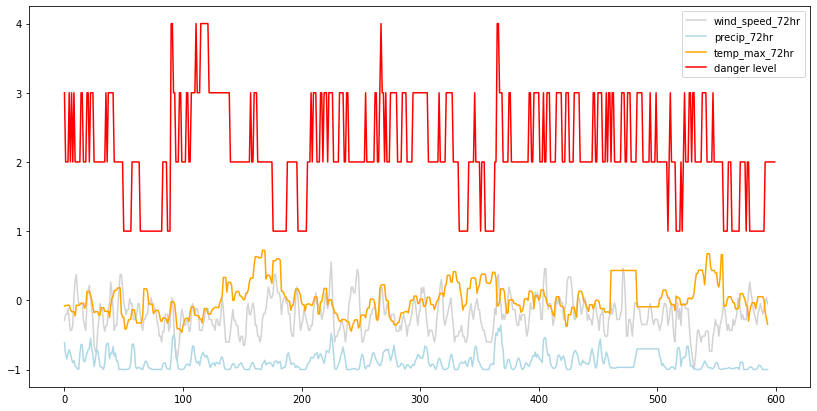

In [22]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(wind, color='lightgrey', label='wind_speed_72hr')
ax.plot(precip, color='lightblue', label='precip_72hr')
ax.plot(temp, color='orange', label='temp_max_72hr')
ax.plot(ploty, color='r', label='danger level')

ax.legend()
plt.show()

I should generalize the normalization process for input variables for X_train, X_val, and X_test (over each column).

In [23]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(594, 3) (600, 1)
(594, 3) (600, 1)
(594, 3) (600, 1)
(594, 3) (600, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(595, 3) (601, 1)
(593, 3) (599, 1)
(341, 3) (347, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)


In [24]:
for (arr, label) in zip(X_val, y_val):
    print(arr.shape, label.shape)

(594, 3) (600, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)


In [25]:
for (arr, label) in zip(X_test, y_test):
    print(arr.shape, label.shape)

(174, 3) (180, 1)
(592, 3) (598, 1)
(595, 3) (601, 1)


In [26]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    
    return padded

**Maybe instead of padding, we should cut off data where it doesn't fit into full batches?**

In [27]:
sequence_length = 8
X_train = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test = [pad_sequence(arr, sequence_length) for arr in y_test]

In [28]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (608, 1)
(600, 3) (600, 1)
(344, 3) (352, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [29]:
# reshape data into (samples, timesteps, features)
# https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
X_concat = np.concatenate(X_train)
y_concat = np.concatenate(y_train)

print(X_concat.shape)
print(y_concat.shape)

(9344, 3)
(9360, 1)


In [30]:
print(np.unique(y_concat))

[0. 1. 2. 3. 4.]


In [31]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [32]:
batchX, batchY = batch_data(X_concat, y_concat, sequence_length)

(9336, 8, 3) (9336, 1)


In [33]:
to_print = 10
print(y_concat[sequence_length:sequence_length+to_print], '\n')
for i in range(to_print):
    print(i, batchX[i], batchY[i], '\n')

[[3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [2.]
 [2.]] 

0 [[-0.28915663 -0.61514043 -0.08422584]
 [-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]] [3.] 

1 [[-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]] [2.] 

2 [[-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]
 [ 0.28915663 -0.9

In [34]:
print(np.any(np.isnan(batchX)))

False


In [35]:
np.random.seed(42)
tf.random.set_seed(42)

nodes = 50
batch_size = 8
timesteps = batchX.shape[1]
features = batchX.shape[2]

# design network
model = tf.keras.models.Sequential()
model.add(LSTM(nodes, input_shape=(timesteps, features)))
model.add(Dense(nodes))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [36]:
# specify loss and optimizer
criterion = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=1e-8)

# compile and fit model
model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])
history = model.fit(batchX, batchY, epochs=10, verbose=2, shuffle=False)

Epoch 1/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 2/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 3/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 4/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 5/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 6/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 7/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 8/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 9/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912
Epoch 10/10
292/292 - 1s - loss: 0.0000e+00 - accuracy: 0.1912


**Why is the loss 0 and accuracy unchanging?**

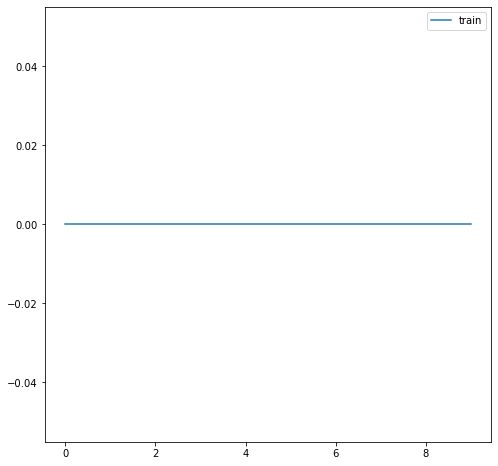

In [37]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['loss'], label='train')
#ax.plot(history.history['val_loss'], label='test')

ax.legend()
plt.show()

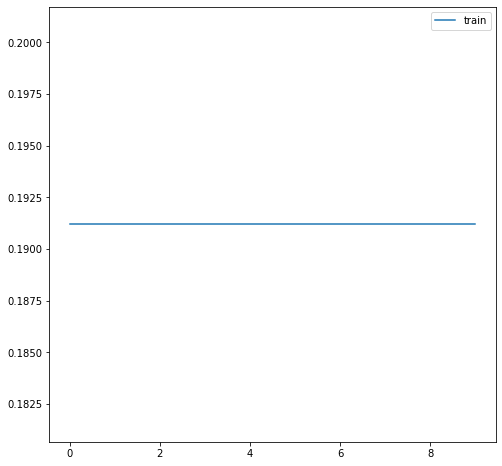

In [38]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['accuracy'], label='train')
#ax.plot(history.history['val_loss'], label='test')

ax.legend()
plt.show()